# Reconhecimento de objetos em imagens com Redes Neurais Convolucionais

## CIFAR-10

## Objetivo

Este Notebook constrói, treina e aplica uma Rede Neural Convolucional para classificar objetos em imagens (fotografias), considerando as 10 categorias abaixo:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

## Conjunto de dados (*Datasets*)

CIFAR é uma sigla do [Canadian Institute For Advanced Research](https://www.cs.toronto.edu/~kriz/cifar.html). O conjunto de dados [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) foi desenvolvido junto com o conjunto de dados CIFAR-100 por pesquisadores do instituto CIFAR para pesquisas de visão computacional.

É um conjunto de dados bem conhecido e amplamente utilizado para benchmarking de algoritmos de visão computacional no campo do aprendizado de máquina.

As imagens desse dataset são pequenas, muito menores do que uma fotografia comum.

CIFAR-10 é um subconjunto rotulado do conjunto de dados de [80 milhões de pequenas imagens](https://en.wikipedia.org/wiki/80_Million_Tiny_Images).

* #### **Dados de treino**: 50.000 imagens 
Utilizado para criar o modelo preditivo/classificador

* #### **Dados de teste**: 10.000 imagens 
Utilizado para avaliar o modelo durante o treinamento

* #### Imagens quadradas coloridas (com 3 canais) de 32 × 32 pixels

* #### Há 6.000 imagens de cada uma das 10 classes

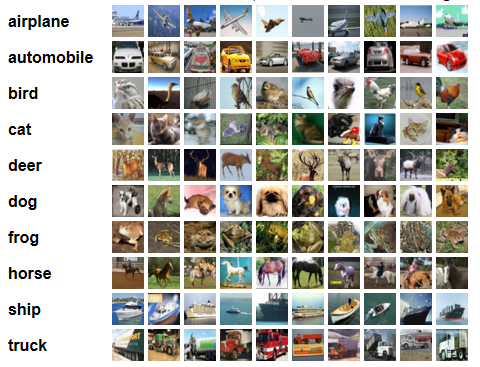

## Habilitando GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carregando os dados

In [2]:
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(trainX, trainY), (testX, testY) = cifar10.load_data()
print('Dados de treino: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Dados de teste: X=%s, y=%s' % (testX.shape, testY.shape))

170508288/170498071 [==============================] - 13s 0us/step
Dados de treino: X=(50000, 32, 32, 3), y=(50000, 1)
Dados de teste: X=(10000, 32, 32, 3), y=(10000, 1)


Abaixo seguem visualizações de algumas imagens do conjunto de dados de treinamento.

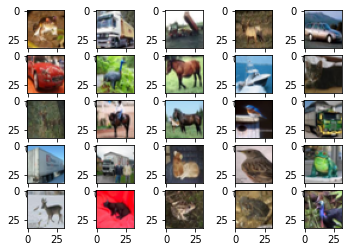

In [3]:
from matplotlib import pyplot
for i in range(25):
	# define subplot
	pyplot.subplot(5,5,i+1)
	# imprime os dados (imagens) 
	pyplot.imshow(trainX[i])
# mostra a figura
pyplot.show()

## Normalizando os dados

Sabemos que os valores de pixel para cada imagem no conjunto de dados são inteiros sem sinal no intervalo entre preto e branco, ou 0 e 255 (em cada um dos 3 canais).

Normalizamos então os valores para o intervalo [0,1]. Isso envolve primeiro a conversão do tipo de dados de inteiros sem sinal em flutuantes e, em seguida, a divisão dos valores de pixel pelo valor máximo.

In [4]:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

## *OneHotEncoder*

Sabemos que são 10 classes (rótulos) e que as classes são representadas como inteiros únicos.

Podemos então usar uma codificação para a classe de cada amostra, transformando o inteiro em um vetor binário de 10 elementos com 1 para o índice do valor da classe e 0 valores para todas as outras classes. Podemos fazer isso com a função to_categorical().

In [5]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Construção da Rede Neural Convolucional

Características particulares dessa versão:
 
* **Transferência de aprendizagem**: abordagem **inicialização dos pesos** usando o modelo pré-treinado ResNet 50
* include_top=False: Somente a cama de extração de atributos
* Pesos inicializados com Imagenet e treinados novamente para o CIFAR (pesos são ajustados/treinados)
* Uso da camada [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) para aumentar a dimensão das imagens de 32x32 para 256x256.

Obs: trabalhar com imagens muito pequenas com um modelo de CNN muito profundo pode ocasionar uma perda significativa de recursos/atributos ao longo da rede o que certamente afetará significativamente na acurácia da classificação.

In [7]:
# Importação dos pacotes
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout

# carrega o modelo base ResNET com pesos Imagenet (que serão ajustados/treinados)
base_model = ResNet50(include_top=False, weights = 'imagenet', input_shape=(256, 256, 3))

# Monta o modelo completo utilizando o modelo base
model = Sequential()
model.add(UpSampling2D((2,2),input_shape=(32, 32, 3)))
model.add(UpSampling2D((2,2)))
model.add(UpSampling2D((2,2)))
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step


### Sumário da arquitetura da rede neural convolucional

Execute o comando abaixo para obter um resumo da arquitetura da rede neural convolucional construída e para ver também o número de parâmetros da mesma.

Primeiramente do modelo base:

In [8]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 up_sampling2d_1 (UpSampling  (None, 128, 128, 3)      0         
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (None, 256, 256, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                        

Compilação da Rede Neural Convolucional

Esta versão utiliza o RMSprop.

A função de perda (função de erro): **entropia cruzada categórica** adequada para classificação multiclasse

E a métrica de desempenho 'accuracy' (proporção de casos corretamente previstos).

In [11]:
# Compilando a rede
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(learning_rate=2e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Treinamento da Rede Neural Convolucional


In [12]:
history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_data=(testX, testY))

Epoch 1/10
2500/2500 [==============================] - 755s 293ms/step - loss: 1.6285 - accuracy: 0.4652 - val_loss: 0.6424 - val_accuracy: 0.8220
Epoch 2/10
2500/2500 [==============================] - 733s 293ms/step - loss: 0.9887 - accuracy: 0.7039 - val_loss: 0.4408 - val_accuracy: 0.8916
Epoch 3/10
2500/2500 [==============================] - 733s 293ms/step - loss: 0.7243 - accuracy: 0.8040 - val_loss: 0.3113 - val_accuracy: 0.9193
Epoch 4/10
2500/2500 [==============================] - 731s 293ms/step - loss: 0.5637 - accuracy: 0.8575 - val_loss: 0.2531 - val_accuracy: 0.9338
Epoch 5/10
2500/2500 [==============================] - 731s 292ms/step - loss: 0.4537 - accuracy: 0.8921 - val_loss: 0.2124 - val_accuracy: 0.9445
Epoch 6/10
2500/2500 [==============================] - 731s 292ms/step - loss: 0.3652 - accuracy: 0.9161 - val_loss: 0.2069 - val_accuracy: 0.9452
Epoch 7/10
2500/2500 [==============================] - 730s 292ms/step - loss: 0.3006 - accuracy: 0.9333 - val_

## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação.

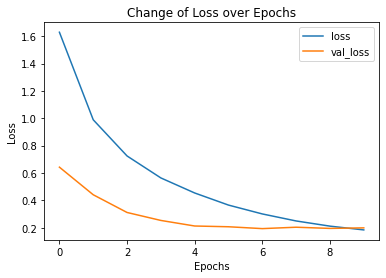

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação.

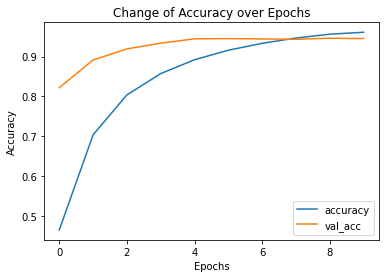

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_acc'])
plt.show()

## Teste da rede neural treinada (fazendo predições)

Após o treinamento da rede, vamos realizar alguns testes com imagens que não fazem parte dos dados originais de treino e teste.

Cada imagem a ser testada deve ser redimensionada para o formato utilizado no treinamento da rede neural (32x32) e convertida para um array.

Carregamento das imagens testes

In [16]:
from google.colab import files
uploaded = files.upload()

Saving imagens_testes.zip to imagens_testes.zip


Descompactando os dados e conferindo a estrutura de diretórios

In [17]:
!unzip -uq imagens_testes.zip
!ls -l

total 284
-rw-r--r-- 1 root root   9953 Sep 30  2020 0.jpg
-rw-r--r-- 1 root root  19927 Sep 30  2020 1.jpg
-rw-r--r-- 1 root root  18285 Sep 30  2020 2.jpg
-rw-r--r-- 1 root root  15947 Sep 30  2020 3.jpg
-rw-r--r-- 1 root root  24834 Sep 30  2020 4.jpg
-rw-r--r-- 1 root root  17501 Sep 30  2020 5.jpg
-rw-r--r-- 1 root root   5935 Sep 30  2020 6.jpg
-rw-r--r-- 1 root root   7544 Sep 30  2020 7.jpg
-rw-r--r-- 1 root root   6500 Sep 30  2020 8.jpg
-rw-r--r-- 1 root root   7446 Sep 30  2020 9.jpg
-rw-r--r-- 1 root root 132780 Jun 20 03:16 imagens_testes.zip
drwxr-xr-x 1 root root   4096 Jun 15 13:42 sample_data


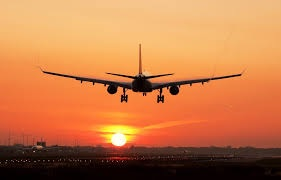

airplane 




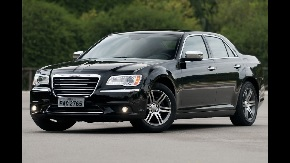

automobile 




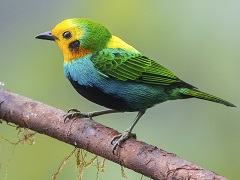

bird 




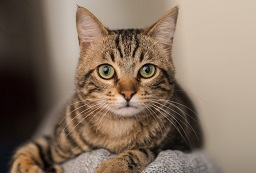

cat 




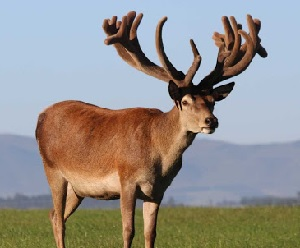

deer 




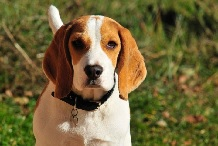

dog 




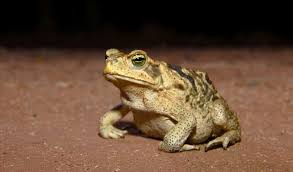

frog 




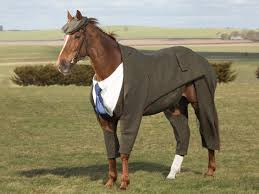

horse 




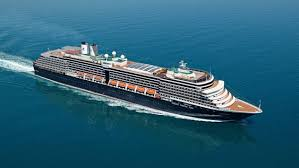

ship 




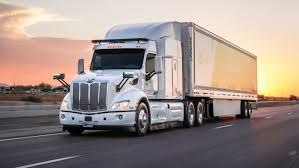

truck 




In [18]:
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Image

Repetir_teste = 'S'
num_img = -1

while num_img < 9:
    num_img = num_img + 1
    file_name = str(num_img)+'.jpg'
    imagem_teste = image.load_img(file_name, target_size = (32, 32))
    imagem_teste = image.img_to_array(imagem_teste)
    imagem_teste = np.expand_dims(imagem_teste, axis = 0)
    # prepara os pixels
    imagem_teste = imagem_teste.astype('float32')
    imagem_teste = imagem_teste/255.0
    predicao = np.argmax(model.predict(imagem_teste),axis=-1)         
    classe = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    # exibe a imagem teste             
    display(Image(file_name)) 
    print(classe[int(predicao)],'\n\n')   